# Normalisation Histogram
## Manual Contrast Stretching
Task:

- Read cameraman.png as grayscale.

- Find the real min and max pixel values in the image.

- Implement the Linear Stretching Formula manually using Numpy (No cv.normalize).

- Show the original and the new image side-by-side.

- Constraint: Do not use for loops. Use Numpy vectorization.

    - important note:

        ```text
        # WRONG (uint8 overflow risk)
        # res = (img - min_val) * 255 / (max_val - min_val) 

        # CORRECT
        img_float = img.astype(float)
        res = (img_float - min_val) * 255.0 / (max_val - min_val)
        res_uint8 = res.astype(np.uint8)
        ```

(np.float64(-0.5), np.float64(250.5), np.float64(250.5), np.float64(-0.5))

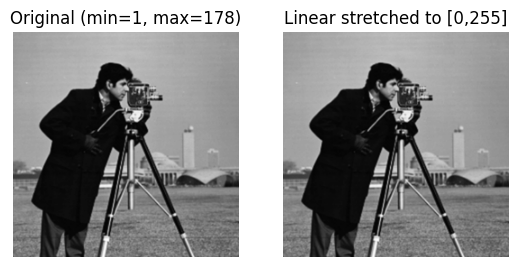

In [74]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# cv.IMREAD_GRAYSCALE is the same as 0 for reading an image in grayscale mode
cameraman_img = cv.imread("img/cameraman2.png", cv.IMREAD_GRAYSCALE)
# cameraman_img=cv.imread("img/cameraman2.png",0)

# to prevent overflow risk I change image type to float before calculating normalization
cameraman_img_float = cameraman_img.astype(float)
min_val = cameraman_img.min()
max_val = cameraman_img.max()
new_image = (cameraman_img_float - min_val) * 255 / (max_val - min_val)

# change new_image type to uint8
new_image_uint8 = new_image.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title(f"Original (min={min_val}, max={max_val})")
plt.imshow(cameraman_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Linear stretched to [0,255]")
plt.imshow(new_image_uint8, cmap="gray")
plt.axis("off")

# Equalisation Histogram
- OpenCV Way (Black Box)
    ```bash
    equalized_img = cv.equalizeHist(img)
    ```
- numpy way:
    1. Get Histogram
        ```bash
        hist, bins = np.histogram(img.flatten(), 256, [0,256])
        ```

    2. Get CDF
        ```bash
        cdf = hist.cumsum()
        ```

    3. Normalize CDF (so max is 255)
        ```bash
        cdf_normalized = cdf * 255 / cdf.max()
        ```

    4. Map
    - We use the CDF as a "Look Up Table" (LUT).
    - If pixel value is 'v', new value is cdf_normalized[v]
        ```bash
        equalized_img = cdf_normalized[img]
        ```

Conceptual Question: 

Imagine an image that contains only two values: 50% of pixels are Black (0) and 50% of pixels are White (255).

1. What does the Histogram look like?

2. What does the CDF look like? (at 0, at 128, at 255)

3. If we apply Histogram Equalization to this specific image, will it change?

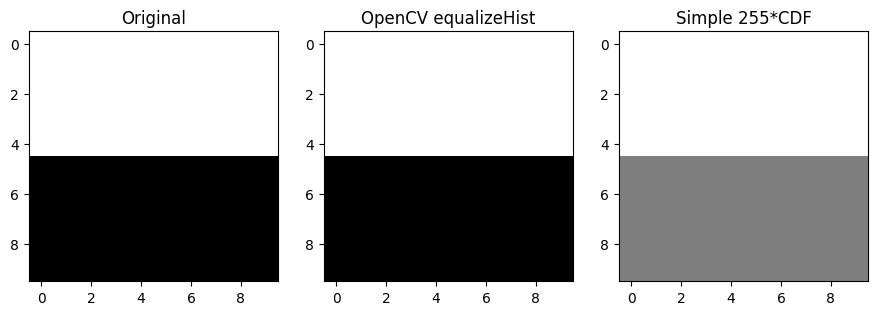

LUT_simple[0] = 127 LUT_simple[255] = 255


In [75]:
img = np.zeros((10, 10), dtype=np.uint8)
img[0:5, :] = 255

# histogram + CDF
hist1 = np.bincount(img.ravel(), minlength=256)
cdf1 = hist1.cumsum() / hist1.sum()

# "simplified" equalization LUT: new = 255 * CDF(old)
lut_simple = np.floor(255 * cdf1).astype(np.uint8)

eq_simple = lut_simple[img]                 # apply LUT
eq_opencv = cv.equalizeHist(img)            # OpenCV equalization

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img, cmap="gray", vmin=0, vmax=255); 
plt.subplot(1,3,2); plt.title("OpenCV equalizeHist"); plt.imshow(eq_opencv, cmap="gray", vmin=0, vmax=255); 
plt.subplot(1,3,3); plt.title("Simple 255*CDF"); plt.imshow(eq_simple, cmap="gray", vmin=0, vmax=255); 
plt.tight_layout(); plt.show()

print("LUT_simple[0] =", lut_simple[0], "LUT_simple[255] =", lut_simple[255])


Example 1 (easy: only 4 gray levels)
Image A (10×10)

Values are only in {0, 64, 128, 255}:
```bash
A =
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
```

tasks for A:

- Histogram?
- Normalized histogram? 
- Contrast stretching (min–max)?
- Histogram equalization?


In [76]:
# Define Image A based on the description
# Rows 0-4 (5 rows): Cols 0-4 (5 cols): 0, Cols 5-9 (5 cols): 64
# Rows 5-9 (5 rows): Cols 0-4 (5 cols): 128, Cols 5-9 (5 cols): 255
A = np.zeros((10, 10), dtype=np.uint8)
A[0:5, 0:5] = 0
A[0:5, 5:10] = 64
A[5:10, 0:5] = 128
A[5:10, 5:10] = 255

# 1. Histogram (counts)
hist, bins = np.histogram(A.flatten(), 256, [0, 256])

# 2. Normalized Histogram
total_pixels = A.size  # 10 * 10 = 100
# probab
prob_hist = hist / total_pixels
# print(prob_hist.sum()) # must be 1

# 3. Contrast Stretching
min_gray = A.min()
max_gray = A.max()
# safty check: If the image has constant intensity (e.g. all pixels = 128):
# (max_gray == min_gray)
if max_gray == min_gray:
    A_stretched = A.copy()
else:
    A_stretched = (A - min_gray) * 255 / (max_gray - min_gray)


# 4. Histogram Equalization
# cdf
cdf = hist.cumsum()
print(cdf)
# normalize cdf -> cdf*255/cdf.max()
normalized_cdf = cdf * 255 / cdf.max()
# using normalized_cdf as LUT to create the new image
# LUT= normalized_cdf ==> imagine this as a dictionnary:
# normalized_cdf= {0:64 , 64:128 , 128:191 , 255:255 } ={key,value}
# equalized_new_A= normalized_cdf [key]
equalized_new_A = normalized_cdf[A]
print(f"old A: {np.histogram(A)}")
print(f"equalized A: {np.histogram(equalized_new_A)}")

[ 25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  7

Task:

Write a function equalize_manual(image) that:

- Calculates the histogram of the input image.
- Computes the CDF.
- Normalizes the CDF to range $[0, 255]$.
- Uses Numpy indexing (LUT) to map the old pixels to new pixels.
- Returns the equalized image.

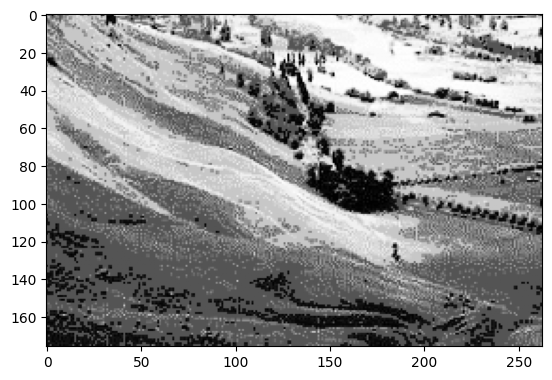

In [77]:
def equalize_manual(image):
    # Histogram (counts)
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    # cdf
    cdf = hist.cumsum()
    # normalize cdf -> cdf*255/cdf.max()
    normalized_cdf = cdf * 255 / cdf.max()
    # using normalized_cdf as LUT to create the new image
    equalized_new_image = normalized_cdf[image]
    return equalized_new_image

landscape=cv.imread("img/landscape.png",0)
plt.imshow(equalize_manual(landscape),cmap="gray")

Code Review:
equalize_manual is logically correct, but there is one dangerous type error:
- normalized_cdf is float.normalized_cdf[image] 
- returns an image of float.

Fix: Always cast the LUT to uint8 before applying it: 
```python
normalized_cdf = (cdf * 255 / cdf.max()).astype(np.uint8).
```

- Why? 

If you pass this float image to OpenCV later, it expects floats to be $0.0-1.0$. Your values are $0.0-255.0$. It will appear all white.

---